# DMA Fall '20

In [1]:
NAME = "Yin Qiu"
COLLABORATORS = ""

---

# Lab 3: Decision Trees

**Please read the following instructions very carefully**

## Working on the assignment / FAQs
- **Always use the seed/random_state as *42* wherever applicable** (This is to ensure repeatability in answers, across students and coding environments) 
- Questions can be either autograded and manually graded.
- The type of question and the points they carry are indicated in each question cell
- An autograded question has 3 cells
     - **Question cell** : Read only cell containing the question
     - **Code Cell** : This is where you write the code
     - **Grading cell** : This is where the grading occurs, and **you are required not to edit this cell**
- Manually graded questions only have the question and code cells. **All manually graded questions are explicitly stated**
- To avoid any ambiguity, each question also specifies what *value* must be set. Note that these are dummy values and not the answers
- If an autograded question has multiple answers (due to differences in handling NaNs, zeros etc.), all answers will be considered.
- Most assignments have bonus questions for extra credit, do try them out! 
- You can delete the `raise NotImplementedError()` for all questions.
- **Submitting the assignment** : Download the '.ipynb' file from Colab and upload it to bcourses. Do not delete any outputs from cells before submitting.
- That's about it. Happy coding!


## About the dataset
This assignment uses a dataset obtained from the JSE Data Archive that contains biological and self-reported activity traits of a sample of college students at a single university uploaded in 2013. The study associated with these data focused on exploring if a correspondence exists between eye color and and other traits. You will be using gender as the target/label in this lab.

FEATURE DESCRIPTIONS: 
- Color (Blue, Brown, Green, Hazel, Other)
- Age (in years)
- YearinSchool (First, Second, Third, Fourth, Other)
- Height (in inches)
- Miles (distance from home town of student to Ames, IA) 
- Brothers (number of brothers)
- Sisters (number of sisters)
- CompTime (number of hours spent on computer per week)
- Exercise (whether the student exercises Yes or No)
- ExerTime (number of hours spent exercising per week)
- MusicCDs (number of music CDs student owns)
- PlayGames (number of hours spent playing games per week)
- WatchTV (number of hours spent watching TV per week

https://ww2.amstat.org/publications/jse/jse_data_archive.htm (eyecolorgenderdata.csv)


In [2]:
from collections import Counter, defaultdict
import itertools
import pandas as pd
import numpy as np
import operator
import math

!wget -nc http://people.ischool.berkeley.edu/~zp/course_datasets/eye_color.zip
!unzip -u eye_color.zip
!ls
df = pd.read_csv('Eye_Color.csv')
# remove NA's and reset the index
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df = df.reset_index(drop=True)

df.head()

--2020-09-14 02:11:48--  http://people.ischool.berkeley.edu/~zp/course_datasets/eye_color.zip
Resolving people.ischool.berkeley.edu (people.ischool.berkeley.edu)... 128.32.78.16
Connecting to people.ischool.berkeley.edu (people.ischool.berkeley.edu)|128.32.78.16|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://people.ischool.berkeley.edu/~zp/course_datasets/eye_color.zip [following]
--2020-09-14 02:11:48--  https://people.ischool.berkeley.edu/~zp/course_datasets/eye_color.zip
Connecting to people.ischool.berkeley.edu (people.ischool.berkeley.edu)|128.32.78.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23344 (23K) [application/zip]
Saving to: ‘eye_color.zip’

eye_color.zip       100%[===================>]  22.80K  --.-KB/s    in 0.1s    

2020-09-14 02:11:49 (167 KB/s) - ‘eye_color.zip’ saved [23344/23344]

Archive:  eye_color.zip
  inflating: Eye_Color.csv           
  inflating: Eye_Color_Dataset_Descripti

,gender,age,year,eyecolor,height,miles,brothers,sisters,computertime,exercise,exercisehours,musiccds,playgames,watchtv
0,female,18,first,hazel,68.0,195.0,0,1,20.0,Yes,3.0,75.0,6.0,18.0
1,male,20,third,brown,70.0,120.0,3,0,24.0,No,0.0,50.0,0.0,3.0
2,female,18,first,green,67.0,200.0,0,1,35.0,Yes,3.0,53.0,8.0,1.0
3,male,23,fourth,hazel,74.0,140.0,1,1,5.0,Yes,25.0,50.0,0.0,7.0
4,female,19,second,blue,62.0,60.0,0,1,5.0,Yes,4.0,30.0,2.0,5.0


---
**Question 1 (0.5 points, autograded)**: How many males and females exist in the dataset?

In [3]:
df['gender'].value_counts()

# raise NotImplementedError()

female    1078
male       910
Name: gender, dtype: int64

In [4]:
#The value set in the variables must be integers
num_males = 910 #Replace 0 with the actual value
num_females = 1078 #Replace 0 with the actual value

# raise NotImplementedError()

In [5]:
#This is an autograded cell, do not edit
print(num_males, num_females)

910 1078


---
**Question 2 (0.5 points, autograded)**: What is the Gini Index of this dataset, using males and females as the target classes?

In [6]:
p = num_males /(num_males + num_females) # probability of being male
gini_gender = 2*p*(1-p)
gini_gender

# raise NotImplementedError()

0.49642927990478075

In [7]:
#The value set in the variable must be float
gini_index = gini_gender #Replace 0 with the actual value / formula

# raise NotImplementedError()

In [8]:
#This is an autograded cell, do not edit
print(gini_index)

0.49642927990478075


---
## Best Split of a numeric feature
**Question 3 (1.5 points, autograded)**: What is the best split point of the 'height' feature? (Still using males and females as the target classes, assuming a binary split)

Recall that, to calculate the best split of this numeric field, you'll need to order your data by 'height', then consider the midpoint between each pair of consecutive heights as a potential split point, then calculate the Gini Index for that partitioning. You'll want to keep track of the best split point and its Gini Index (remember that you are trying to minimize the Gini Index). 

There are a lot of ways to do this. Some are very fast, others very slow. One tip to make this run quickly is, as you consecutively step through the data and calculate the Gini Index of each possible split point, keep a running total of the number of rows for each candidate that are located above and below the split point. 

Some Python tips: 

* Counter(), from the collections module, is a special dictionary for counting values of a key
* zip() lets you concatenate lists into a list of tuples (for example, if we have a list of the candidates and a list of transaction amounts, zip(candidate_list, transaction_amount) would give us a list of (candidate, transaction amount) pairs

In [9]:
df1 = df[['height','gender']]
c = Counter(df1['height'])

h_keys = sorted(list(c.keys()))
# update c with tuple of (male_count, female_count) for each height
for height in h_keys:
  count_gender = df1[df1['height']==height]['gender'].value_counts()
  if 'male' not in count_gender.keys():
    c[height] = (0, count_gender['female'])
  elif 'female' not in count_gender.keys():
    c[height] = (count_gender['male'], 0)
  else:
    c[height] = (count_gender['male'], count_gender['female'])
c

Counter({44.0: (0, 1),
         52.0: (0, 1),
         54.0: (0, 1),
         56.0: (0, 3),
         57.0: (0, 2),
         58.0: (2, 1),
         59.0: (0, 5),
         60.0: (1, 20),
         61.0: (4, 27),
         62.0: (4, 79),
         63.0: (1, 98),
         64.0: (3, 143),
         65.0: (8, 150),
         66.0: (19, 120),
         67.0: (38, 154),
         68.0: (62, 100),
         69.0: (80, 67),
         70.0: (126, 56),
         71.0: (100, 19),
         72.0: (168, 17),
         73.0: (84, 4),
         74.0: (70, 3),
         75.0: (59, 2),
         76.0: (35, 1),
         77.0: (23, 2),
         78.0: (15, 0),
         79.0: (5, 0),
         80.0: (1, 1),
         82.0: (1, 1),
         85.0: (1, 0)})

In [10]:
gini_lst = []
num_f_higher = num_females # initial num of female above split point
num_m_higher = num_males # initial num of male above split point
total = num_females + num_males

for i in range(len(h_keys)-1):
  split_point = (h_keys[i] + h_keys[i+1])/2
  num_f_higher -= c[h_keys[i]][1] # running total of female counts above select height
  num_m_higher -= c[h_keys[i]][0] # running total of male counts above select height
  num_higher = num_f_higher + num_m_higher
  num_f_lower = num_females - num_f_higher
  num_m_lower = num_males - num_m_higher
  num_lower = total - num_higher
  # calculate gini index at split point, function is gini(D) = (D1/D) * 2p_1(1-p_1) + (D2/D) * 2p_2(1-p_2)
  gini = (num_higher/total)*2*(num_f_higher/num_higher)*(num_m_higher/num_higher)+(num_lower/total)*2*(num_f_lower/num_lower)*(num_m_lower/num_lower)
  gini_lst.append(gini)

min_i = np.argmin(gini_lst) # get the index of min of gini index
best_split_point = (h_keys[min_i] + h_keys[min_i+1])/2 # find the split point at height
print(best_split_point)

68.5


In [11]:
#The value set in the variable must be float
best_split_point = 68.5 #Replace 0 with the actual value

# YOUR CODE HERE
# raise NotImplementedError()

In [12]:
#This is an autograded cell, do not edit
print(best_split_point)

68.5


---
**Question 4 (0.5 points, autograded)**: What is the Gini index of the best split point of the 'height' feature? (Still using males and females as the target classes, assuming a binary split)


In [13]:
gini_lst[min_i]

# raise NotImplementedError()

0.2655288120702919

In [14]:
#The value set in the variable must be float
gini_of_best_split_point = 0.2655288120702919 #Replace 0 with the actual value

# YOUR CODE HERE
# raise NotImplementedError()

In [15]:
#This is an autograded cell, do not edit
print(gini_of_best_split_point)

0.2655288120702919


---
**Question 5 (0.5 points, autograded)**: How much does this partitioning reduce the Gini Index over the Gini index of the overall dataset?

In [16]:
gini_gender - gini_of_best_split_point
# raise NotImplementedError()

0.23090046783448887

In [17]:
#The value set in the variable must be float
gini_difference = 0.23090046783448887 #Replace 0 with the actual value

# YOUR CODE HERE
# raise NotImplementedError()

In [18]:
#This is an autograded cell, do not edit
print(gini_difference)

0.23090046783448887


---
**Question 6 (0.5 points, autograded)**: How many 'female' and 'male' rows are shorter than the best height split point?

In [19]:
shorter = [c[h_keys[i]] for i in range(min_i+1)]
count_shorter = [sum(i) for i in zip(*shorter)] # zip() with * can upzip the list of tuples, and sum() in respect to index position
count_shorter # sum of counts of male and female shorter than best height split point
# raise NotImplementedError()

[142, 905]

In [20]:

#The value set in the variable must be integer
female_rows_below = 905 #Replace 0 with the actual value
male_rows_below = 142 #Replace 0 with the actual value
# YOUR CODE HERE
# raise NotImplementedError()

In [21]:
#This is an autograded cell, do not edit
print(female_rows_below, male_rows_below)

905 142


---
**Question 7 (0.5 points, autograded)**: How many 'female' and 'male' rows are taller than the best height split point?

In [22]:
taller = [c[h_keys[i]] for i in range(min_i+1,len(h_keys))]
count_taller = [sum(i) for i in zip(*taller)]
count_taller
# raise NotImplementedError()

[768, 173]

In [23]:
#The value set in the variable must be integer
female_rows_above = 173 #Replace 0 with the actual value
male_rows_above = 768 #Replace 0 with the actual value
# YOUR CODE HERE
# raise NotImplementedError()

In [24]:
#This is an autograded cell, do not edit
print(female_rows_above, male_rows_above)

173 768


---
## Best Split of a Categorial Variable

**Question 8 (0.5 points, autograded)**: How many possible splits are there of the eyecolor feature? (Assuming binary split)

Python tip: the combinations function of the itertools module allows you to enumerate combinations of a list. You might want to Google 'power set'.


In [25]:
def power_set(s):
  return list(itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(1, len(s)-2)))
  
eyecolors = set(df['eyecolor'])
color_splits = power_set(eyecolors)
color_splits
# raise NotImplementedError()

[('brown',),
 ('other',),
 ('blue',),
 ('hazel',),
 ('green',),
 ('brown', 'other'),
 ('brown', 'blue'),
 ('brown', 'hazel'),
 ('brown', 'green'),
 ('other', 'blue'),
 ('other', 'hazel'),
 ('other', 'green'),
 ('blue', 'hazel'),
 ('blue', 'green'),
 ('hazel', 'green')]

In [26]:
#The value set in the variable must be integer
num_of_splits = len(color_splits) #Replace 0 with the actual value
# YOUR CODE HERE
# raise NotImplementedError()

In [27]:
#This is an autograded cell, do not edit
print(num_of_splits)

15


---
**Question 9 (1 points, autograded)**: Which split of eyecolor best splits the female and male rows, as measured by the Gini Index?

In [35]:
df2 = df[['eyecolor', 'gender']]
d = dict(zip(color_splits, np.zeros(num_of_splits))) # initiate a dictionary to store male and female counts for each split point

# update d with tuple of (male_count, female_count) for each color split
for colors in color_splits:
  count_gender2 = df2[df2['eyecolor'].isin(colors)]['gender'].value_counts()
  if 'male' not in count_gender2.keys():
    d[colors] = (0, count_gender2['female'])
  elif 'female' not in count_gender2.keys():
    d[colors] = (count_gender2['male'], 0)
  else:
    d[colors] = (count_gender2['male'], count_gender2['female'])
d

{('blue',): (346, 359),
 ('blue', 'green'): (453, 549),
 ('blue', 'hazel'): (503, 543),
 ('brown',): (278, 327),
 ('brown', 'blue'): (624, 686),
 ('brown', 'green'): (385, 517),
 ('brown', 'hazel'): (435, 511),
 ('brown', 'other'): (300, 345),
 ('green',): (107, 190),
 ('hazel',): (157, 184),
 ('hazel', 'green'): (264, 374),
 ('other',): (22, 18),
 ('other', 'blue'): (368, 377),
 ('other', 'green'): (129, 208),
 ('other', 'hazel'): (179, 202)}

In [41]:
gini_lst2 = []
total = num_females + num_males

for i in range(len(color_splits)):
  num_f_yes = d[color_splits[i]][1] # female counts if yes in color group
  num_m_yes = d[color_splits[i]][0] # male counts if yes in color group
  num_yes = num_f_yes + num_m_yes
  num_f_no = num_females - num_f_yes
  num_m_no = num_males - num_m_yes
  num_no = total - num_yes
  # calculate gini index at split point, function is gini(D) = (D1/D) * 2p_1(1-p_1) + (D2/D) * 2p_2(1-p_2)
  gini2 = (num_yes/total)*2*(num_f_yes/num_yes)*(num_m_yes/num_yes)+(num_no/total)*2*(num_f_no/num_no)*(num_m_no/num_no)
  gini_lst2.append(gini2)

min_i_color = np.argmin(gini_lst2) # get the index of min of gini index
best_split_group = color_splits[min_i_color] # find the best split color group
print(best_split_group)

# raise NotImplementedError()

('green',)


In [42]:
#The value set in the variable must be an array
colour_group_1 = ['green'] #Replace [] with the actual colours/values in the group
colour_group_2 = ['blue', 'brown', 'hazel', 'other'] #Replace [] with the actual colours/values in the group
# YOUR CODE HERE
# raise NotImplementedError()

In [43]:
#This is an autograded cell, do not edit
print(colour_group_1, colour_group_2)

['green'] ['blue', 'brown', 'hazel', 'other']


---
**Question 10 (0.5 points, autograded)**: What is the Gini Index of this best split?

In [44]:
gini_lst2[min_i_color]
# raise NotImplementedError()

0.4930915729509778

In [45]:
#The value set in the variable must be float
gini_of_best_split_group = 0.4930915729509778 #Replace 0 with the actual value

# YOUR CODE HERE
# raise NotImplementedError()

In [46]:
#This is an autograded cell, do not edit
print(gini_of_best_split_group)

0.4930915729509778


---
**Question 11 (0.5 points, autograded)**: How much does this partitioning reduce the Gini Index over the Gini index of the overall dataset?

In [47]:
gini_index - gini_of_best_split_group
# raise NotImplementedError()

0.003337706953802977

In [48]:
#The value set in the variable must be float
gini_difference_2 = 0.003337706953802977 #Replace 0 with the actual value

# YOUR CODE HERE
# raise NotImplementedError()

In [49]:
#This is an autograded cell, do not edit
print(gini_difference_2)

0.003337706953802977


---
**Question 12 (1 points, autograded)** : How many 'female' rows and 'male' rows are in your first partition? How many 'female' rows and 'male' rows are in your second partition?

In [56]:
# first partition
num_m_yes = d[color_splits[min_i_color]][0]
num_f_yes = d[color_splits[min_i_color]][1]
print('First partition:', colour_group_1, '\nmale count', num_m_yes , 'female count', num_f_yes)
# second partition
print('Second partition:', colour_group_2, '\nmale count', num_males - num_m_yes, 'female count', num_females - num_f_yes)

First partition: ['green'] 
male count 107 female count 190
Second partition: ['blue', 'brown', 'hazel', 'other'] 
male count 803 female count 888


In [57]:
#The value set in the variable must be integer, order doesn't matter
partition1_male = 107 #Replace 0 with the actual value
partition1_female = 190 #Replace 0 with the actual value
partition2_male = 803 #Replace 0 with the actual value
partition2_female = 888 #Replace 0 with the actual value

# YOUR CODE HERE
# raise NotImplementedError()

In [58]:
#This is an autograded cell, do not edit
print(partition1_male, partition1_female, partition2_male, partition2_female)

107 190 803 888


---
## Training a decision tree
**Question 13 (1 points, autograded)**: Using all of the features in the original dataframe read in at the top of this notebook, train a decision tree classifier that has a depth of three (not including the root node). What is the accuracy of this classifier on the training data?

Scikit-learn classifiers require class labels and features to be in numeric arrays. As such, you will need to turn your categorical features into numeric arrays using DictVectorizer. This is a helpful notebook for understanding how to do this: http://nbviewer.ipython.org/gist/sarguido/7423289. You can turn a pandas dataframe of features into a dictionary of the form needed by DictVectorizer by using df.to_dict('records'). Make sure you remove the class label first (in this case, gender). If you use the class label as a feature, your classifier will have a training accuracy of 100%! The example notebook link also shows how to turn your class labels into a numeric array using sklearn.preprocessing.LabelEncoder().

In [117]:
df['year'].replace('first"','first', inplace=True) # fix a typo in the dataset

In [118]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Dict to Vectorizer for all features
X = df.drop(['gender'], axis=1).to_dict('records')
vec = DictVectorizer()
features = vec.fit_transform(X).toarray()

# Label encoder for target
y = df['gender']
le = LabelEncoder()
le.fit(['male', 'female'])
target = le.transform(y)

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.6, test_size=0.4, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1192, 22) (796, 22) (1192,) (796,)


In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

print(accuracy_score(y_train, y_pred))

0.8699664429530202


In [120]:
#The value set in the variable must be float
accuracy = 0.8699664429530202 #Replace 0 with the actual value

# YOUR CODE HERE
# raise NotImplementedError()

In [121]:
#This is an autograded cell, do not edit
print(accuracy)

0.8699664429530202


---
**Question 14 (1 points, manually graded)**: Using the following code snippet, export your decision tree to graphviz and visualize it. In your write-up, write down the interpretation of the rule at each node which is used to perform the splitting.

In order to install graphviz, you may need to download the tool from [this website](https://graphviz.gitlab.io), and then pip3/conda install the python libraries you do not have.

Mac users can use ```brew install graphviz``` instead of following the link, and linux users can do the same using their favourite package manager (for example, Ubuntu users can use ```sudo apt-get install graphviz```, followed by the necessary pip3/conda installations.

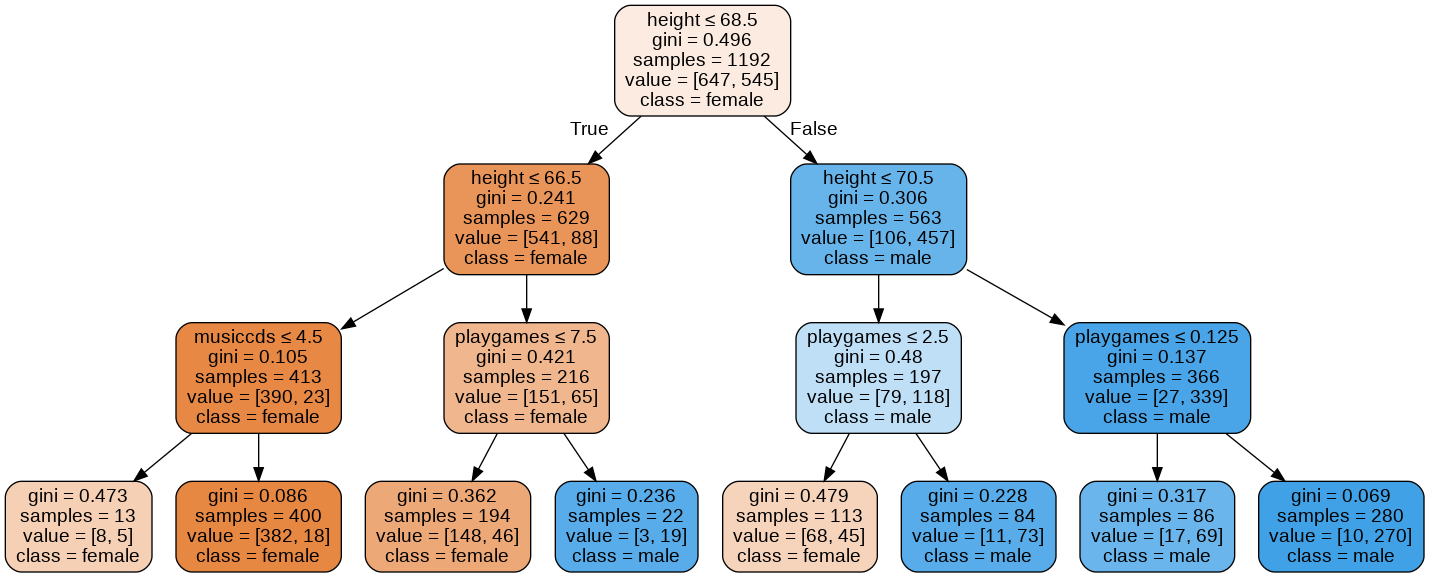

In [123]:
from IPython.display import Image  
import pydotplus 
import pydot
from sklearn.externals.six import StringIO

dotfile = StringIO() 
tree.export_graphviz(clf, out_file=dotfile,
                     feature_names=vec.get_feature_names(),  
                         class_names=['female', 'male'],  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dotfile.getvalue())
Image(graph.create_png())

# Interpretation: 
# The first split point is whether someone is no taller than 68.5 inches; 
# if true, the second split point on the left is whether someone is no taller than 66.5 inches; 
# if false, the seoncd split point on the right is whether someone is no shorter than 70.5 inches;

# If someone is no taller than 66.5 inches, the third split point is asking whether he/she owns less than 4.5 music CDs; 
# if someone is taller than 66.5 inches, the third split point is asking whether he/she plays games no more than 7.5.

# If someone is taller than 70.5 inches, the third question is whether he/she plays games no more than 2.5 hours;
# if someone is no taller than 70.5 inches, the third question is whether he/she plays games no more than 0.125 hours;

# Following the thrid split point, we reach max depth of 3 of the tree, and having the leaf nodes as shown below.

#Ignore the cell below, but do not delete it. It is used to grade the image output of this cell.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

---
## Bonus Question (2 points, auto graded)
For each of your leaf nodes, specify the percentage of 'female' rows in that node (out of the total number of rows at that node)


In [ ]:
#The value set in the variable must be array
ratios = [] #Replace 0 with the actual value

# YOUR CODE HERE
raise NotImplementedError()


In [ ]:
#This is an autograded cell, do not edit
print(ratios)